# Predicting malignancy of breast cancer cells

### Import packages

In [1]:
%matplotlib inline

from collections import Counter
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

We have developed a model that predicts the malignancy of tumor cells based on their features with an F1 score of 0.96. 

We found a random forest model was well suited for this task. We picked random forest because it:

- can handle the collinearity in the data set.
- gives us flexibility regarding the treatment of missing data.
- is resistant to overfitting.
- provides some interpretability from the feature importances.
- can observe non-linear relationships between features with a high maximum depth.

We performed a grid search on key random forest hyperparameters but found very little sensitivity, which is not surprising.

We observed some collinearity between the "Uniformity of Cell Shape" and "Uniformity of Cell Size" features.

Insights from this data:

- Mitoses has no bearing on predicting the malignancy of tumor cells.
- According to the feature importances, the three most important features are Uniformity of Cell Shape, Uniformity of Cell Size, and Bare Nuclei.

### Import the data from the .csv file

In [2]:
cols = ['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion','Single Epithelial Cell Size',
        'Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses','Class']
df = pd.read_csv('breast-cancer-wisconsin.csv',names = cols)

### Initial look at the data to check for the shape, datatype, missing data

In [3]:
df.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
df.shape

(699, 11)

In [5]:
df.describe()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
Sample code number             699 non-null int64
Clump Thickness                699 non-null int64
Uniformity of Cell Size        699 non-null int64
Uniformity of Cell Shape       699 non-null int64
Marginal Adhesion              699 non-null int64
Single Epithelial Cell Size    699 non-null int64
Bare Nuclei                    699 non-null object
Bland Chromatin                699 non-null int64
Normal Nucleoli                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


#### "Bare Nuclei data type is object, so need to change this to float

In [7]:
df['Bare Nuclei'].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: Bare Nuclei, dtype: int64

In [8]:
df['Bare Nuclei'] = df['Bare Nuclei'].replace('?',np.nan)
df['Bare Nuclei'] = df['Bare Nuclei'].astype(float)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
Sample code number             699 non-null int64
Clump Thickness                699 non-null int64
Uniformity of Cell Size        699 non-null int64
Uniformity of Cell Shape       699 non-null int64
Marginal Adhesion              699 non-null int64
Single Epithelial Cell Size    699 non-null int64
Bare Nuclei                    683 non-null float64
Bland Chromatin                699 non-null int64
Normal Nucleoli                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: float64(1), int64(10)
memory usage: 60.1 KB


### Initial exploratory data analysis, to get a high level look for colinearity 

/home/abirdsall/miniconda3/envs/insight/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/abirdsall/miniconda3/envs/insight/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


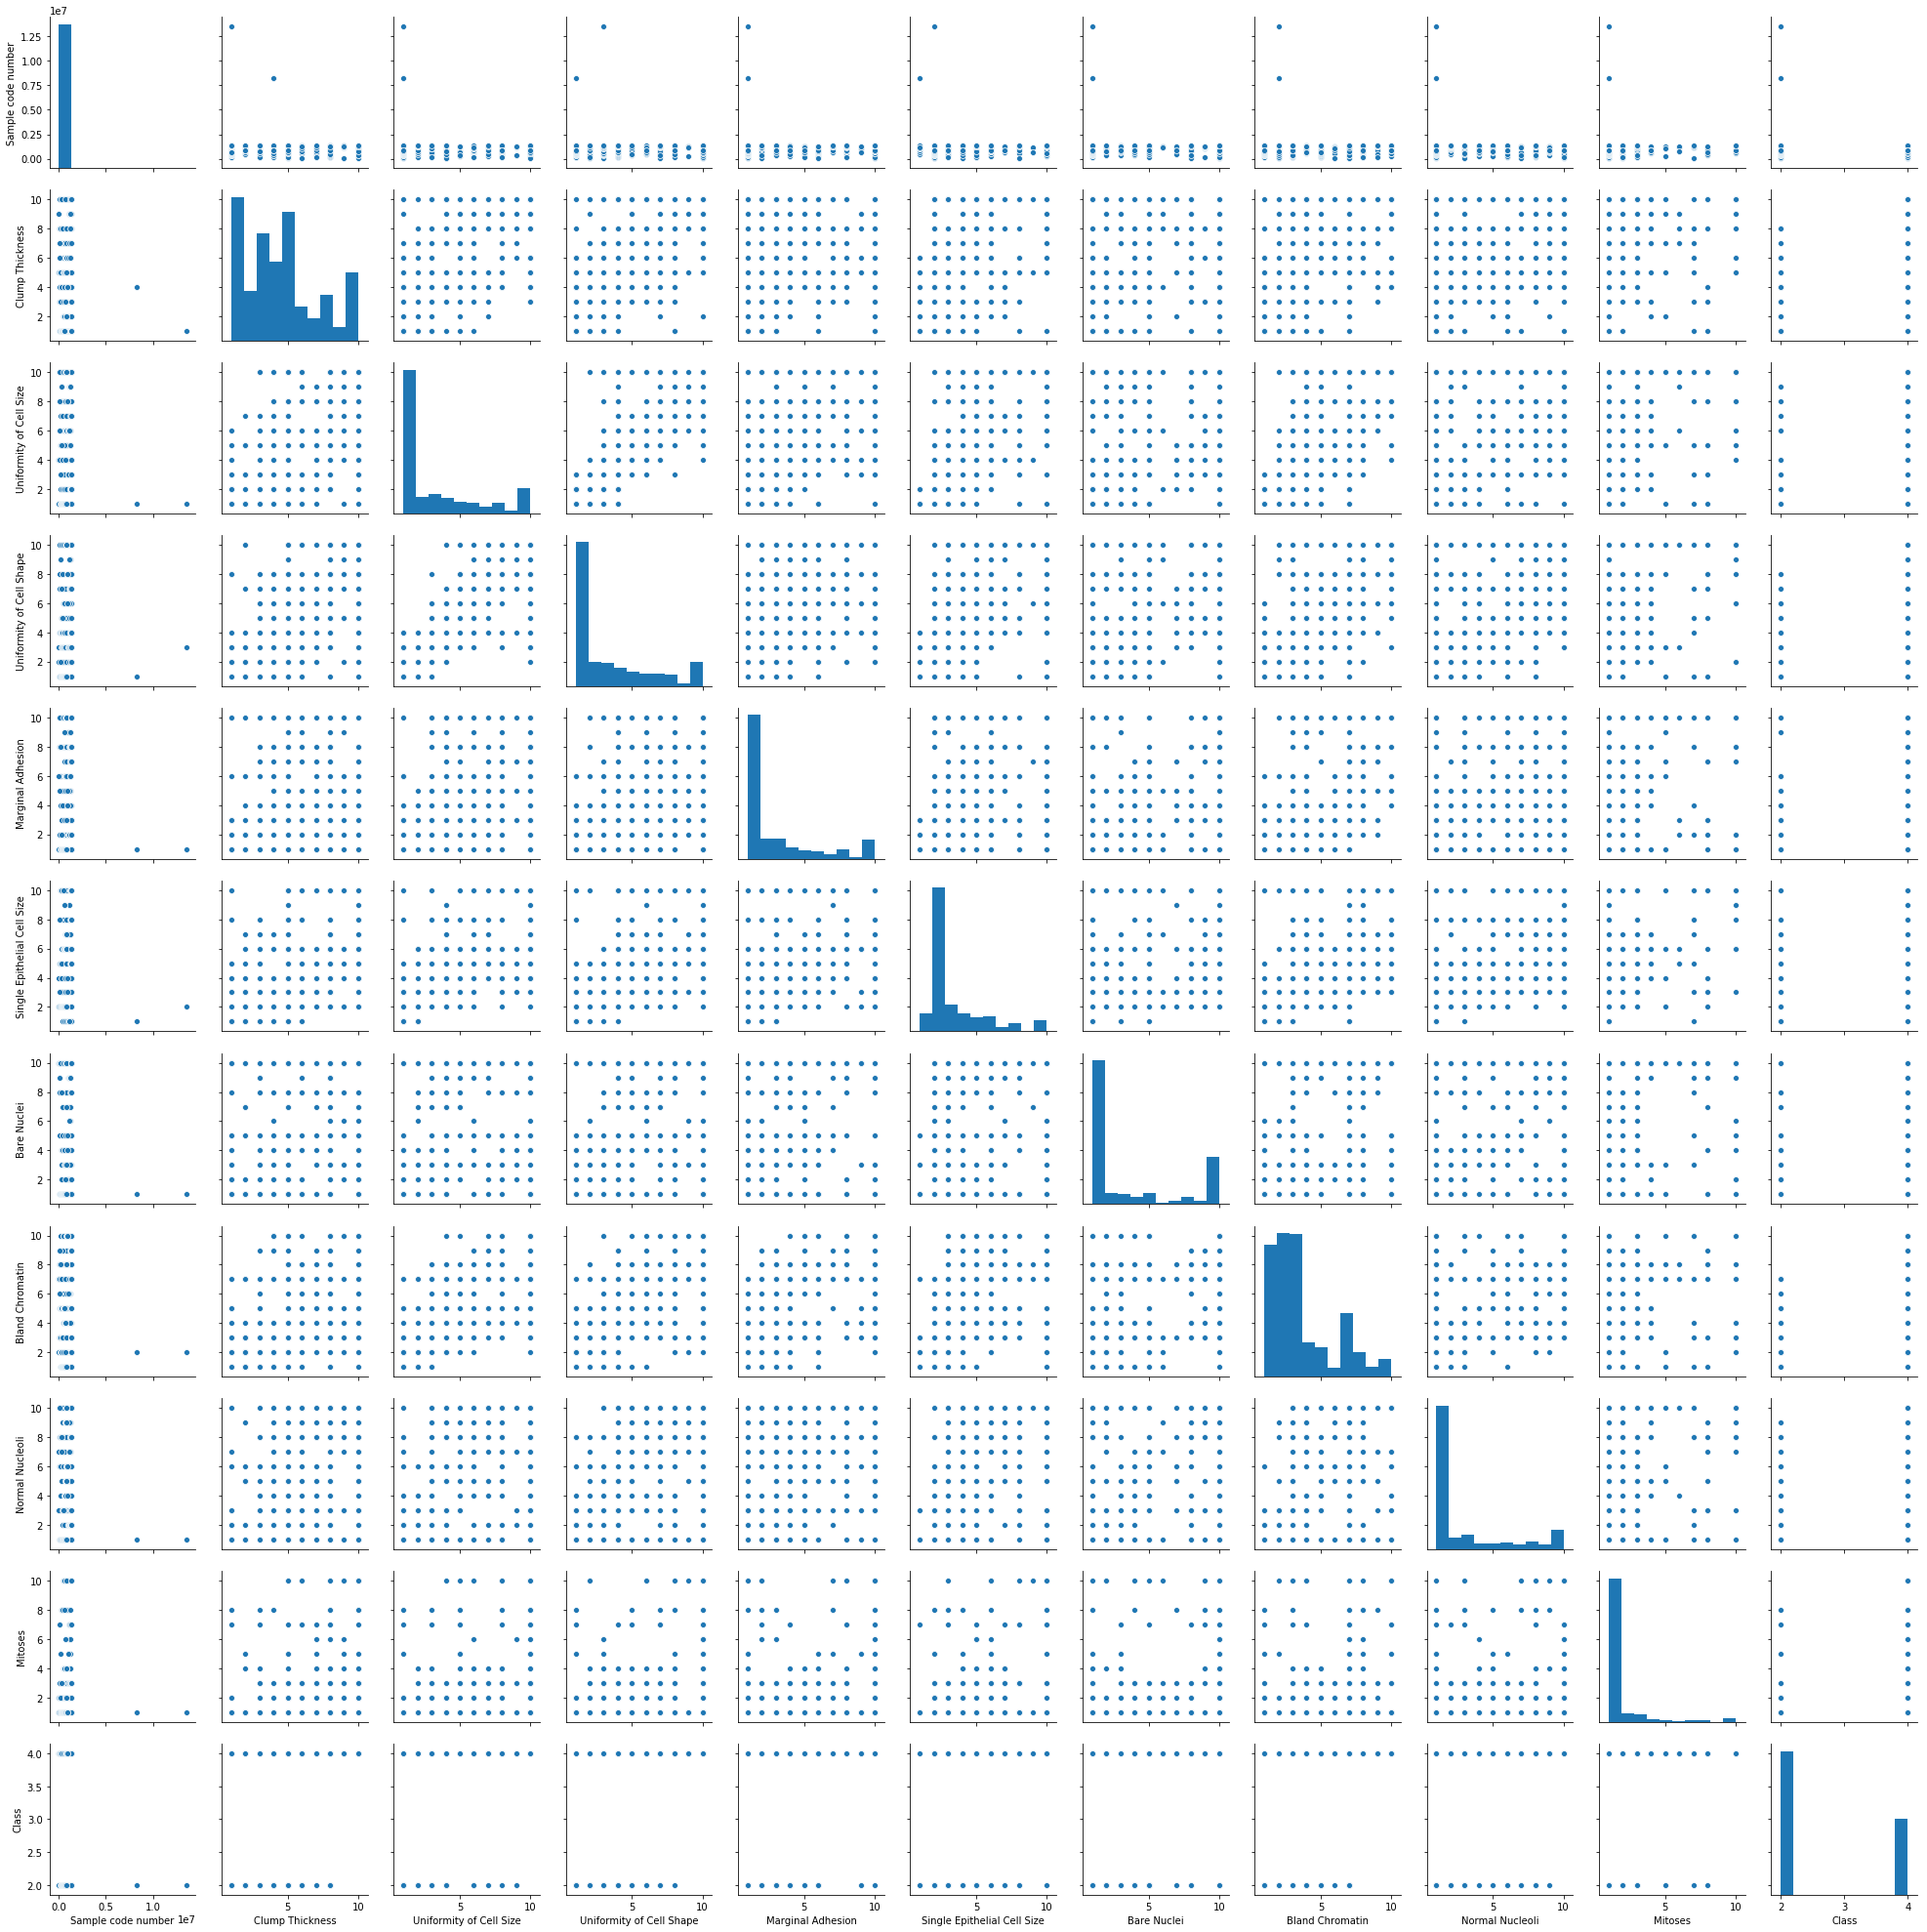

In [10]:
sns.pairplot(df)

#### Uniformity of cell size and cell shape seem to be colinear, we can investigate this better with a correlation matrix

In [11]:
df2 = df.drop(columns = ['Sample code number'])
corrmat = df2.select_dtypes(include='number').corr()

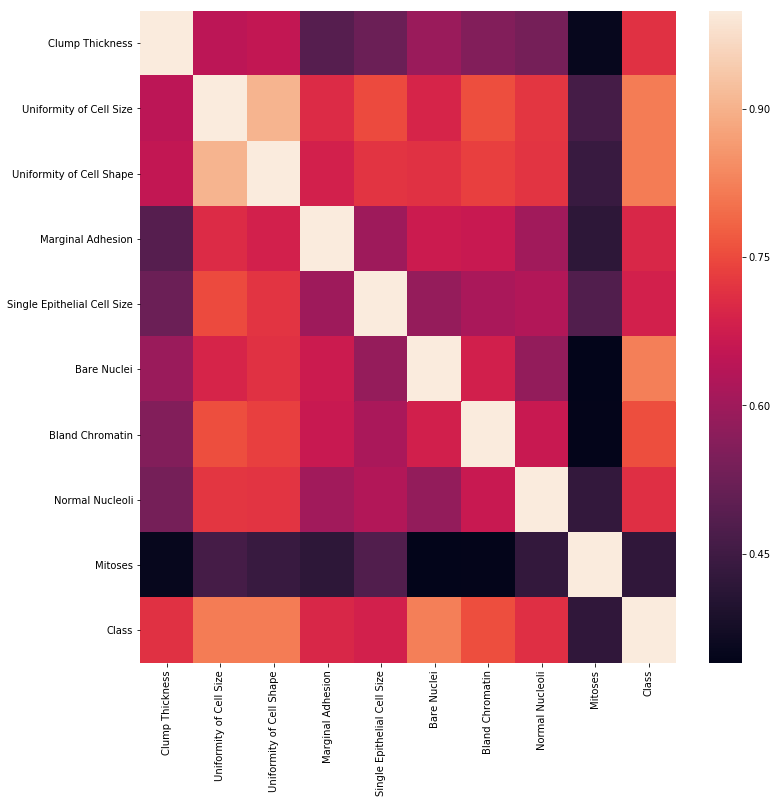

In [12]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(ax=ax, data=corrmat)

<function matplotlib.pyplot.show(*args, **kw)>

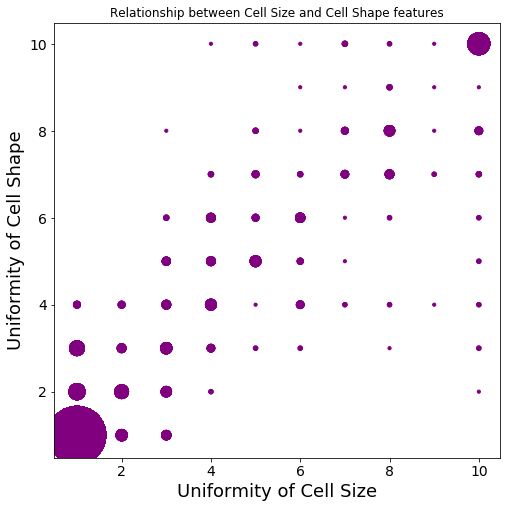

In [13]:
x = df['Uniformity of Cell Size']
y = df['Uniformity of Cell Shape']
c = Counter(zip(x,y))
# create a list of the sizes, here multiplied by 10 for scale
s = [10*c[(xx,yy)] for xx,yy in zip(x,y)]

# plot it

df.plot.scatter('Uniformity of Cell Size','Uniformity of Cell Shape',figsize=(8,8), fontsize = 14, s=s, c='purple')
plt.ylabel('Uniformity of Cell Shape',fontsize = 18)
plt.xlabel('Uniformity of Cell Size', fontsize=18)
plt.title('Relationship between Cell Size and Cell Shape features')
plt.style.use('bmh')
plt.show

### From the correlation matrix above: Mitoses doesn't appear to correlate well with any other features, or with the class label. 

<function matplotlib.pyplot.show(*args, **kw)>

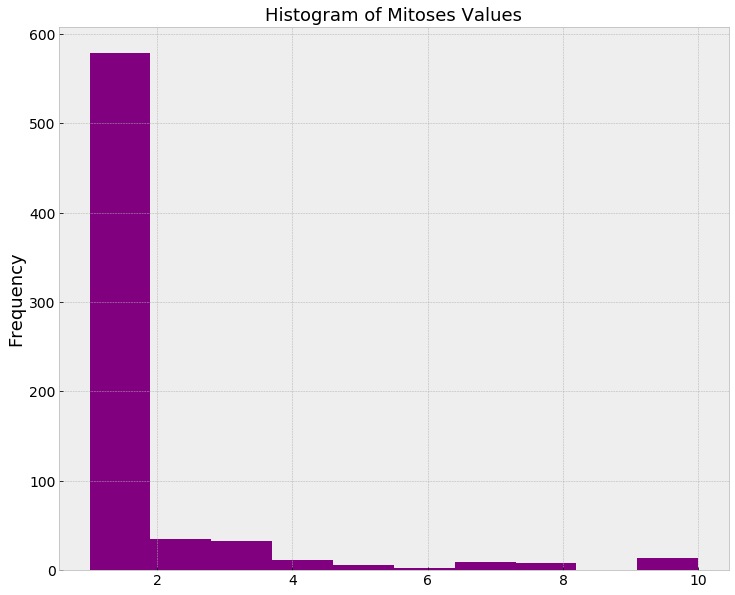

In [14]:
df['Mitoses'].plot.hist(bins=10,figsize=(12,10), fontsize = 14, color='purple')
plt.ylabel('Frequency', fontsize=18)
#plt.xlabel('Mitoses', fontsize=18)
plt.title('Histogram of Mitoses Values', fontsize = 18)
plt.show

#### The majority of the Mitoses values are 1, so this feature may not be contributing much information

## Building initial random forest model

In [15]:
df['Bare Nuclei'] = df['Bare Nuclei'].fillna(99)

df['Class'] = df['Class'].replace({2:0, 4:1})

In [16]:
X = df.drop(columns = ['Sample code number','Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [17]:
clf = RandomForestClassifier(n_estimators=200, random_state=42)
scores = cross_validate(clf, X_train, y_train, cv=10,scoring={'f1':'f1', 'Precision':'precision', 'Recall':'recall'})

print(scores)

{'fit_time': array([0.22758555, 0.21586514, 0.21796012, 0.20844126, 0.21737623,
       0.21389699, 0.21654701, 0.20039296, 0.21074057, 0.20195174]), 'score_time': array([0.05725145, 0.07123518, 0.05367279, 0.05433893, 0.06441116,
       0.0660615 , 0.05539513, 0.05613875, 0.06913114, 0.05576491]), 'test_f1': array([0.96969697, 1.        , 0.97142857, 1.        , 0.94117647,
       0.91428571, 0.88235294, 0.97142857, 1.        , 0.96969697]), 'train_f1': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'test_Precision': array([1.        , 1.        , 0.94444444, 1.        , 0.94117647,
       0.88888889, 0.88235294, 0.94444444, 1.        , 0.94117647]), 'train_Precision': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'test_Recall': array([0.94117647, 1.        , 1.        , 1.        , 0.94117647,
       0.94117647, 0.88235294, 1.        , 1.        , 1.        ]), 'train_Recall': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}


In [18]:
print(scores['test_f1'])

[0.96969697 1.         0.97142857 1.         0.94117647 0.91428571
 0.88235294 0.97142857 1.         0.96969697]


In [19]:
print('f1', np.mean(scores['test_f1']))
print('Precision', np.mean(scores['test_Precision']))
print('Recall', np.mean(scores['test_Recall']))

f1 0.9620066208301502
Precision 0.9542483660130718
Recall 0.9705882352941178


In [20]:
def make_importances_chart(importances, title):
    with sns.axes_style("white", rc={'axes.spines.right': False,
                                     'axes.spines.top': False,
                                     }):
        fig, ax = plt.subplots()
        plt.barh(range(len(importances)),importances.importance.values, color='purple')
        plt.yticks(range(len(importances)), importances.index.values,  fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
        plt.xlim(0,.3)
        plt.title(title, fontsize=24)


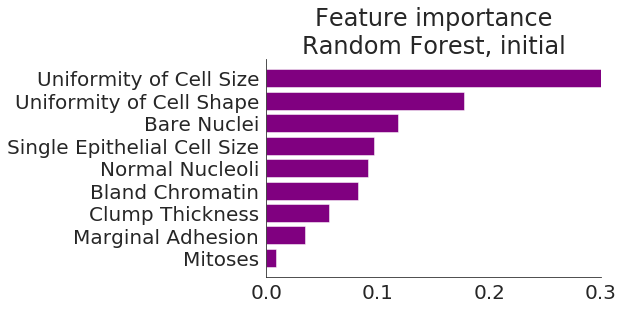

In [21]:
rf_model = clf.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf_model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=True).set_index('feature')
make_importances_chart(importances, "Feature importance\nRandom Forest, initial")

In [22]:
importances.index.values

array(['Mitoses', 'Marginal Adhesion', 'Clump Thickness',
       'Bland Chromatin', 'Normal Nucleoli',
       'Single Epithelial Cell Size', 'Bare Nuclei',
       'Uniformity of Cell Shape', 'Uniformity of Cell Size'],
      dtype=object)

In [23]:
confusion_matrix(y_test, rf_pred)

array([[133,   5],
       [  3,  69]])

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples, labels =['Benign', 'Malignant']):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, labels,fontsize = 25)
    plt.yticks(tick_marks, labels,fontsize = 25)
    
    fmt = '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 25,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label',fontsize=25)
    plt.tight_layout()

Confusion matrix, without normalization
[[133   5]
 [  3  69]]


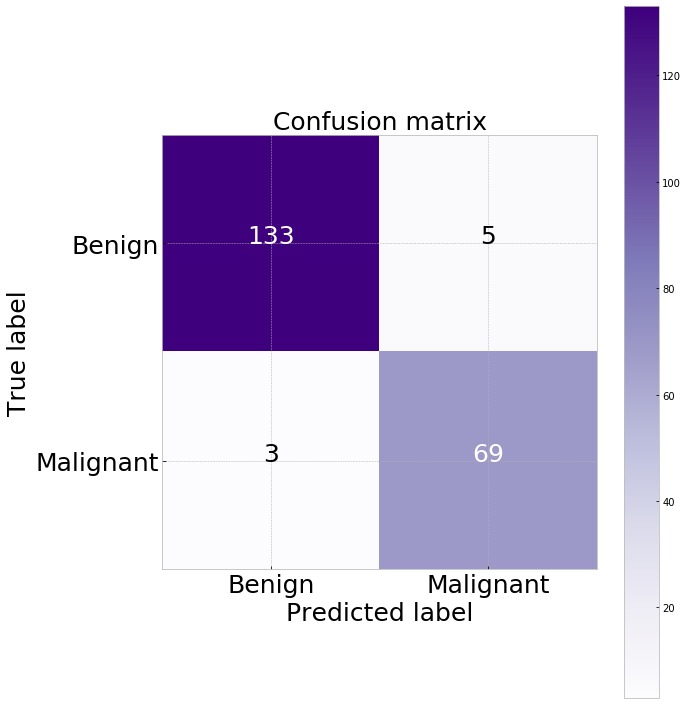

In [25]:
class_names = [0,1]
cnf_matrix = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      normalize = False)

#### Conclusions from initial model

This model worked well, but there is room for improvement.

### Develop new model where missing values are removed

In [26]:
df_clean = df[df['Bare Nuclei'] !=99]
df_clean.shape

(683, 11)

In [27]:
X_clean = df_clean.drop(columns = ['Sample code number','Class'])
y_clean = df_clean['Class']

X_train0, X_test0, y_train0, y_test0 = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42, stratify=y_clean)

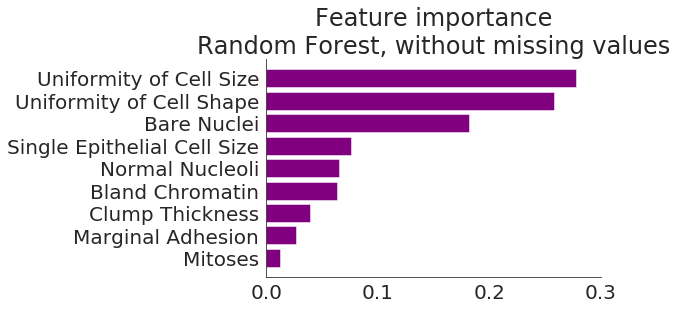

In [28]:
rf_model0 = clf.fit(X_train0, y_train0)
rf_pred0 = rf_model0.predict(X_test0)

importances0 = pd.DataFrame({'feature':X_train0.columns,'importance':np.round(rf_model0.feature_importances_,3)})
importances0 = importances0.sort_values('importance',ascending=True).set_index('feature')
make_importances_chart(importances0, "Feature importance\nRandom Forest, without missing values")

Confusion matrix, without normalization
[[128   5]
 [  3  69]]


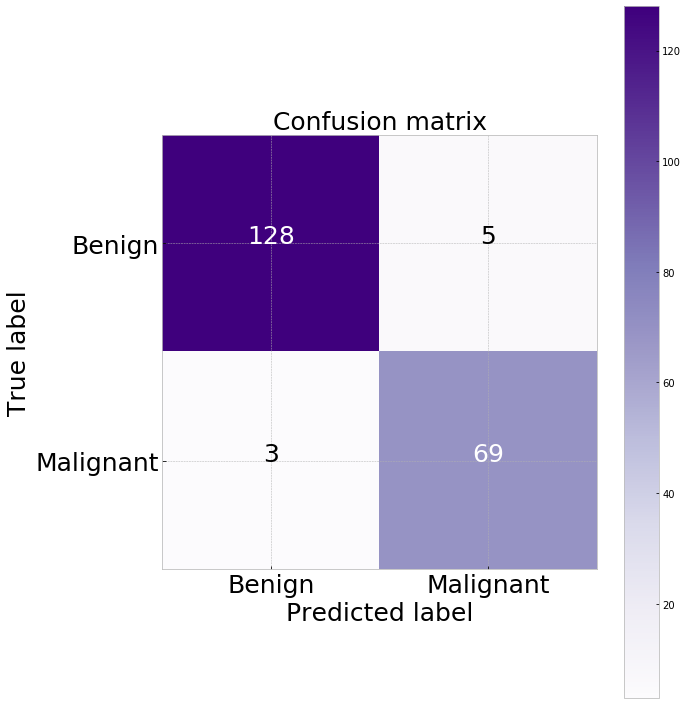

In [29]:
class_names = [0,1]
cnf_matrix = confusion_matrix(y_test0, rf_pred0)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      normalize = False)

#### Conclusions



### Perform grid search to tune RF hyperparameters

In [30]:
params = {'n_estimators':[50,200,500], 'criterion':['gini','entropy'],'min_samples_split':[2,5,10]}
random_search = RandomizedSearchCV(clf, param_distributions=params,n_iter=20, cv = 10, scoring = 'f1')
random_search.fit(X_train, y_train)

/home/abirdsall/miniconda3/envs/insight/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'n_estimators': [50, 200, 500], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [31]:
random_search.best_params_

{'n_estimators': 200, 'min_samples_split': 2, 'criterion': 'gini'}

In [32]:
random_search.cv_results_

/home/abirdsall/miniconda3/envs/insight/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/abirdsall/miniconda3/envs/insight/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/abirdsall/miniconda3/envs/insight/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_a

{'mean_fit_time': array([0.05589938, 0.21040552, 0.55478711, 0.0519388 , 0.22753744,
        0.59923918, 0.05748546, 0.25440845, 0.59184406, 0.05756872,
        0.2372087 , 0.57368712, 0.05741172, 0.21939652, 0.54297576,
        0.05494845, 0.21938758, 0.55797036]),
 'std_fit_time': array([0.00766277, 0.0133635 , 0.05185899, 0.0050539 , 0.0324612 ,
        0.0462501 , 0.0096779 , 0.02057194, 0.04476575, 0.00511611,
        0.00999807, 0.02653872, 0.00452763, 0.00679061, 0.01666917,
        0.00366761, 0.0115637 , 0.02198841]),
 'mean_score_time': array([0.00656049, 0.02167296, 0.04740725, 0.00641539, 0.02180948,
        0.05285914, 0.00761218, 0.02396364, 0.049879  , 0.00732784,
        0.02233658, 0.04964354, 0.00667031, 0.02056856, 0.04889491,
        0.007196  , 0.02047927, 0.06877098]),
 'std_score_time': array([0.00126804, 0.00299947, 0.00617744, 0.0007999 , 0.00268363,
        0.00746211, 0.0015594 , 0.00278105, 0.00490666, 0.00172841,
        0.00331748, 0.00561373, 0.00099559, 

#### Conclusions

Very little effect of hyperparameters on RF performance.

### Try gradient boost classifier

Does not have mitoses removed.

In [33]:
gbc = GradientBoostingClassifier(n_estimators = 200, max_depth = 25)
scores = cross_validate(gbc, X_train, y_train, cv=10,scoring={'f1':'f1', 'Precision':'precision', 'Recall':'recall'})

In [34]:
print('f1', np.mean(scores['test_f1']))
print('Precision', np.mean(scores['test_Precision']))
print('Recall', np.mean(scores['test_Recall']))

f1 0.9273586707410237
Precision 0.9339297385620915
Recall 0.9227941176470587


In [35]:
gbc_model = gbc.fit(X_train, y_train)
gbc_pred = gbc_model.predict(X_test)
confusion_matrix(y_test, gbc_pred)

array([[128,  10],
       [  6,  66]])

Confusion matrix, without normalization
[[128  10]
 [  6  66]]


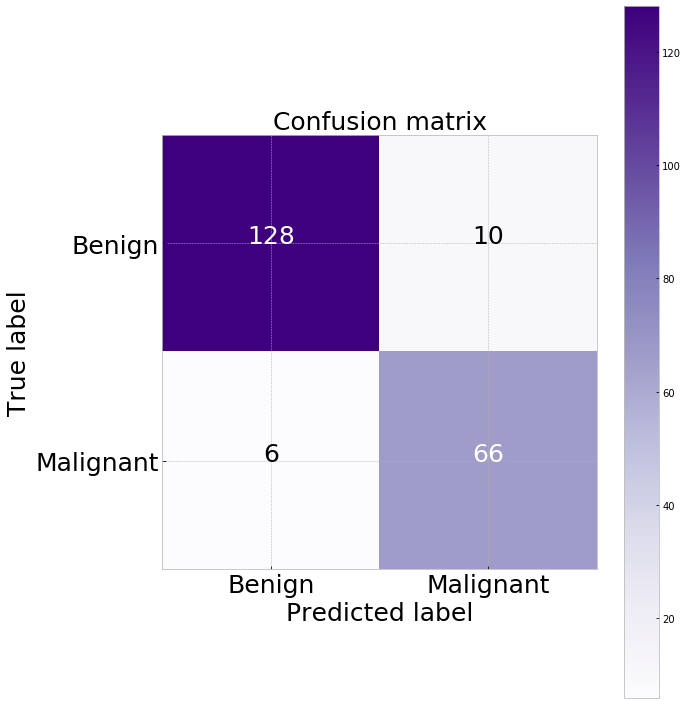

In [36]:
class_names = [0,1]
cnf_matrix = confusion_matrix(y_test, gbc_pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      normalize = False)

#### Conclusion

Gradient boost base performance is lower than RF base performance. Therefore, we kept iterating with the random forest.

### Try random forest classifier without Mitoses

Our EDA showed almost all mitoses scores were 1, suggesting including mitoses as a feature may not be very helpful.

In [37]:
X_noMit = df_clean.drop(columns = ['Sample code number','Mitoses','Class'])
y_noMit = df_clean['Class']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_noMit, y_noMit, test_size=0.3, random_state=42, stratify=y_noMit)

In [38]:
scores = cross_validate(clf, X_train1, y_train1, cv=10,scoring={'f1':'f1', 'Precision':'precision', 'Recall':'recall'})
print('f1', np.mean(scores['test_f1']))
print('Precision', np.mean(scores['test_Precision']))
print('Recall', np.mean(scores['test_Recall']))

f1 0.9550528393175451
Precision 0.9531372549019608
Recall 0.9588235294117646


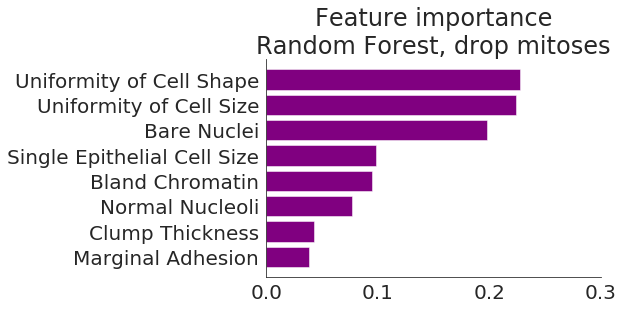

In [39]:
rf_model1 = clf.fit(X_train1, y_train1)
rf_pred1 = rf_model1.predict(X_test1)

importances1 = pd.DataFrame({'feature':X_train1.columns,'importance':np.round(rf_model1.feature_importances_,3)})
importances1 = importances1.sort_values('importance',ascending=True).set_index('feature')
make_importances_chart(importances1, "Feature importance\nRandom Forest, drop mitoses")

In [40]:
confusion_matrix(y_test1, rf_pred1)

array([[128,   5],
       [  2,  70]])

Confusion matrix, without normalization
[[128   5]
 [  2  70]]


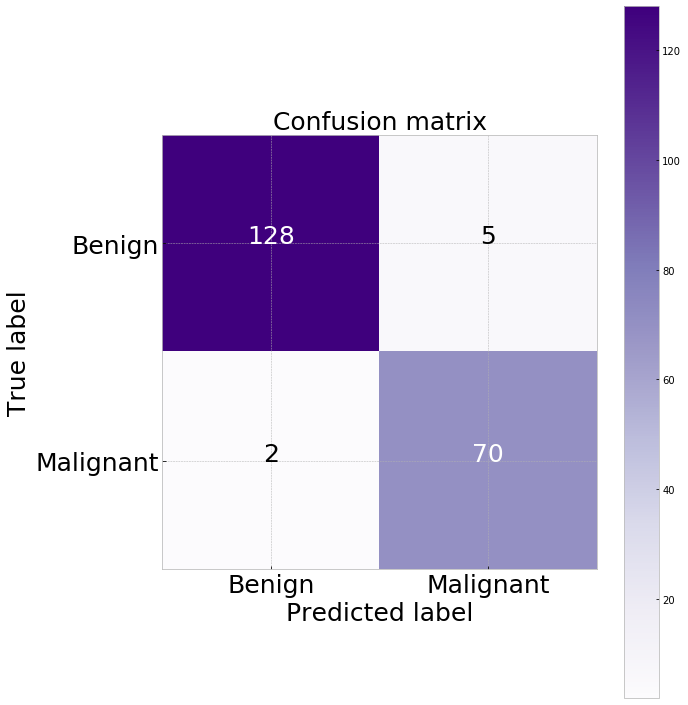

In [41]:
class_names = [0,1]
cnf_matrix = confusion_matrix(y_test1, rf_pred1)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      normalize = False)

#### Conclusions

Adding mitoses helps the performance of RF.

### Try XGBoost classifier

In [42]:
xgb = XGBClassifier(n_estimators=250)
scores = cross_validate(xgb,X_train1, y_train1, cv = 10, scoring={'f1':'f1', 'Precision':'precision', 'Recall':'recall'})
print('f1', np.mean(scores['test_f1']))
print('Precision', np.mean(scores['test_Precision']))
print('Recall', np.mean(scores['test_Recall']))

f1 0.9555996944232238
Precision 0.9538807189542483
Recall 0.9588235294117646


Confusion matrix, without normalization
[[128   5]
 [  1  71]]


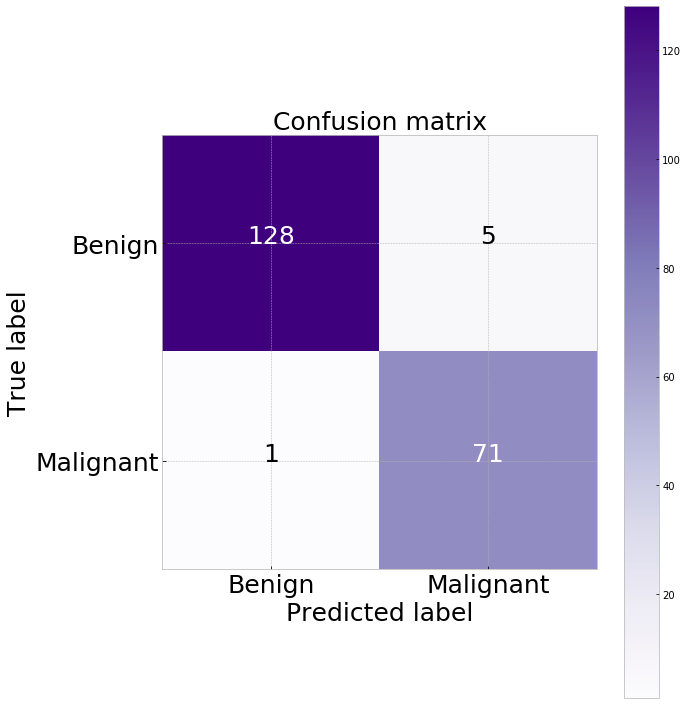

In [45]:
xgb_model = xgb.fit(X_train1, y_train1)
xgb_pred = xgb_model.predict(X_test1)

confusion_matrix(y_test1, xgb_pred)

class_names = [0,1]
cnf_matrix = confusion_matrix(y_test1, xgb_pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      normalize = False)

#### Conclusion

XGBoost performance almost identical to the highest-performance RF (with mitoses removed).